<a href="https://colab.research.google.com/github/TomMaullin/BLM/blob/master/PLS_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PLS implementation in python

This code implements the PLS algorithm for estimating the parameters of linear mixed effects models as described in [Bates (2015)](https://www.jstatsoft.org/article/view/v067i01/v67i01.pdf).

## Pip Installations

Pip install everything.**bold text**

In [1]:
!pip install numpy
!pip install cvxopt
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install sparse
!pip install nilearn
!pip install nibabel
!pip install dask

     |████████████████████████████████| 102kB 4.2MB/s 
     |████████████████████████████████| 3.5MB 15.8MB/s 
  Found existing installation: numba 0.40.1
    Uninstalling numba-0.40.1:
      Successfully uninstalled numba-0.40.1
     |████████████████████████████████| 2.4MB 5.1MB/s 



## Python Imports




We need:
 - `numpy` for matrix handling.
 - `scipy` for minimising the likelihood.
 - `cvxopt` for sparse cholesky.
 - `pandas` for quick reading and writing of csv files.
 - `os` for basic commandline functions
 - `time` for timing functions.
 - `matplotlib` for making displays

In [2]:
import numpy as np
import cvxopt
from cvxopt import cholmod, umfpack, amd, matrix, spmatrix, lapack
import pandas as pd
from scipy.optimize import root
from scipy.optimize import minimize
import scipy.sparse
import os
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import sparse
import nibabel as nib
import nilearn
import sparse

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Helper Functions

This section contains miscellaneous functions used to help the `PLS` function as well as the general manipulation of the Sparse Cholesky decomposition given by `cvxopt`.



### Sparse Cholesky Decomposition function

This function takes in a square matrix **M** and outputs **P** and **L** from it's sparse cholesky decomposition of the form **PAP'=LL**'.

Note: P is given as a permutation vector rather than a matrix.
 
---
 
The following inputs are required for this function:

---

 - **M**: The matrix to be sparse cholesky decomposed as an spmatrix from the cvxopt package.
 - **perm**: Input permutation (*optional*, one will be calculated if not)
 - **retF**: Return the factorisation object or not
 - **retP**: Return the permutation or not
 - **retL**: Return the lower cholesky or not

---

In [0]:
def sparse_chol(M, perm=None, retF=False, retP=True, retL=True):

    # Quick check that M is square
    if M.size[0]!=M.size[1]:
        raise Exception('M must be square.')

    # Set the factorisation to use LL' instead of LDL'
    cholmod.options['supernodal']=2

    if not perm is None:
        # Make an expression for the factorisation
        F=cholmod.symbolic(M,p=perm)
    else:
        # Make an expression for the factorisation
        F=cholmod.symbolic(M)

    # Calculate the factorisation
    cholmod.numeric(M, F)

    # Empty factorisation object
    factorisation = {}

    if retF:

        # Calculate the factorisation again (buggy if returning L for
        # some reason)
        F2=cholmod.symbolic(M,p=perm)
        cholmod.numeric(M, F2)

        # If we want to return the F object, add it to the dictionary
        factorisation['F']=F2

    if retP:

        # Set p to [0,...,n-1]
        P = cvxopt.matrix(range(M.size[0]), (M.size[0],1), tc='d')

        # Solve and replace p with the true permutation used
        cholmod.solve(F, P, sys=7)

        # Convert p into an integer array; more useful that way
        P=cvxopt.matrix(np.array(P).astype(np.int64),tc='i')

        # If we want to return the permutation, add it to the dictionary
        factorisation['P']=P

    if retL:

        # Get the sparse cholesky factor
        L=cholmod.getfactor(F)
        
        # If we want to return the factor, add it to the dictionary
        factorisation['L']=L

    # Return P and L
    return(factorisation)

### Inverse mapping function

This function takes in a lower triangular 
block diagonal matrix, lambda, and maps it to the original vector of parameters, theta.

---
The following inputs are required for this function:

---

 - **Lambda**: The sparse lower triangular block diagonal matrix.
 
---


In [0]:
def inv_mapping(Lambda):

    # List the unique elements of lambda (in the
    # correct order; pandas does this, numpy does
    # not)
    theta = pd.unique(list(cvxopt.spmatrix.trans(Lambda)))
    return(theta)

### Calculate mapping function

This function takes in a vector of parameters, theta, and returns indices which maps them the to lower triangular block diagonal matrix, lambda.

---
The following inputs are required for this function:

---

 - **nlevels**: a vector of the number of levels for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2.
 - **nparams**: a vector of the number of variables for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.

All arrays must be np arrays.

In [0]:
def get_mapping(nlevels, nparams):

    # Work out how many factors there are
    n_f = len(nlevels)

    # Quick check that nlevels and nparams are the same length
    if len(nlevels)!=len(nparams):
        raise Exception('The number of parameters and number of levels should be recorded for every grouping factor.')

    # Work out how many lambda components needed for each factor
    n_lamcomps = (np.multiply(nparams,(nparams+1))/2).astype(np.int64)

    # Block index is the index of the next un-indexed diagonal element
    # of Lambda
    block_index = 0

    # Row indices and column indices of theta
    row_indices = np.array([])
    col_indices = np.array([])

    # This will have the values of theta repeated several times, once
    # for each time each value of theta appears in lambda
    theta_repeated_inds = np.array([])
    
    # Loop through factors generating the indices to map theta to.
    for i in range(0,n_f):

        # Work out the indices of a lower triangular matrix
        # of size #variables(factor) by #variables(factor)
        row_inds_tri, col_inds_tri = np.tril_indices(nparams[i])

        # Work out theta for this block
        theta_current_inds = np.arange(np.sum(n_lamcomps[0:i]),np.sum(n_lamcomps[0:(i+1)]))

        # Work out the repeated theta
        theta_repeated_inds = np.hstack((theta_repeated_inds, np.tile(theta_current_inds, nlevels[i])))

        # For each level of the factor we must repeat the lower
        # triangular matrix
        for j in range(0,nlevels[i]):

            # Append the row/column indices to the running list
            row_indices = np.hstack((row_indices, (row_inds_tri+block_index)))
            col_indices = np.hstack((col_indices, (col_inds_tri+block_index)))

            # Move onto the next block
            block_index = block_index + nparams[i]

    # Create lambda as a sparse matrix
    #lambda_theta = spmatrix(theta_repeated.tolist(), row_indices.astype(np.int64), col_indices.astype(np.int64))

    # Return lambda
    return(theta_repeated_inds, row_indices, col_indices)

### Apply mapping function

The below function applies a mapping to a vector of parameters.

---
The following inputs are required for this function:

---

 - **theta**: the vector of theta parameters.
 - **theta_inds**: A vector specifying how many times each theta parameter should be repeated. For example, if theta=[0.1,0.8,0.3] and theta_inds=[1,1,1,2,3,3], then the values to be mapped into the sparse matrix would be [0.1,0.1,0.1,0.8,0.3,0.3].
 - **r_inds**: The row indices of the elements mapped into the sparse matrix.
 - **c_inds**: The column indices of the elements mapped into the sparse matrix.



In [0]:
def mapping(theta, theta_inds, r_inds, c_inds):

    return(spmatrix(theta[theta_inds.astype(np.int64)].tolist(), r_inds.astype(np.int64), c_inds.astype(np.int64)))
    


###Matrix to Vector function

This function takes in a (symmetric, square) matrix and half-vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix, below and including the diagonal, stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ b & d & e \\ c & e & f \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}$$.

In [7]:
def mat2vech(matrix):
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0])
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Return vectorised half-matrix
  return(np.array([matrix[rowinds[perm],colinds[perm]]]).transpose())

# Example:
matrix1 = np.eye(3,3)
print(matrix1*matrix1.transpose())
print(mat2vech(matrix1*matrix1.transpose()))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


## Toy Dataset

This section read ins and formats a toy dataset. The files used here were generated in `R` and with **True** values (those with postfix `True`) being those used to generate the data and **Estimated** (those with postfix `REst`) values being the estimates `R`'s `lmer` package generated from this data.

In [8]:
# Make a data directory
if not os.path.isdir('/Data'):
  os.mkdir('/Data')
  
os.chdir('/Data')

# Clone small git repo containg some csv files.
if not os.path.isdir('/Data/BLMM-testdata'):
  !git clone https://github.com/TomMaullin/BLMM-testdata.git
  

Cloning into 'BLMM-testdata'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.



### Z matrix

The below reads in Z and makes an image of Z transpose.


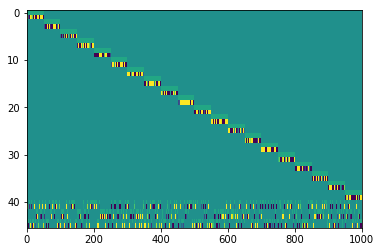

In [9]:
# Read in random effects design matrix and convert it into it's sparse format in
# cvxopt.
Z_3col=pd.read_csv('/Data/BLMM-testdata/Z_3col.csv',header=None).values
Z = cvxopt.spmatrix(Z_3col[:,2].tolist(), (Z_3col[:,0]-1).astype(np.int64), \
                    (Z_3col[:,1]-1).astype(np.int64))

# Create an image of Z'
imshow(np.array(cvxopt.matrix(cvxopt.spmatrix.trans(Z))), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')



### Estimated Random Effects matrix

The below reads in the Random effects variance predicted by `R`'s `lmer`.

In [0]:
# Read in estimated variance
RFXVar_REst =pd.read_csv('/Data/BLMM-testdata/estd_rfxvar.csv',header=None).values

# The RFX variance was stored in a strange way so we need to reformat slightly
RFXVar_REst = spmatrix(RFXVar_REst[RFXVar_REst!=0],[0,0,1,1,2,2,3,3],[0,1,0,1,2,3,2,3])

### Estimated Theta

The below calculates and outputs the `theta` parameter values which `lmer` estimated.

In [11]:
# We now need the Sparse Cholesky decomposition of the RFX variance to obtain 
# the theta values.
f = sparse_chol(RFXVar_REst)

# We map the L matrix from the decomposition to theta
theta_REst = inv_mapping(f['L'])

# This is the desired outcome/theta value of the PLS algorithm. It should match 
# the R output.
print(theta_REst)

[ 1.11365482  0.32356815  2.22872418  4.54822071 -0.17500295  0.42370817]


### Y vector

The response vector is read in here:

In [0]:
Y=matrix(pd.read_csv('/Data/BLMM-testdata/Y.csv',header=None).values)

### X matrix

The fixed effects design matrix is read in here. It consists of an intercept and two random (Gaussian) columns.


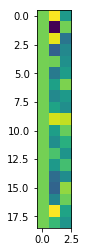

In [13]:
X=matrix(pd.read_csv('/Data/BLMM-testdata/X.csv',header=None).values)

# Image of the first 20 rows of X
imshow(X[1:20,:])

### Number of Levels and Parameters

The number of levels is given by a vector with one entry for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2. 

The number of parameters is given by a vector with one entry for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.

In [0]:
nlevels = np.array([20,3])
nparams = np.array([2,2])

# Number of subjects
n = X.size[0]

### True b values

The true recorded values of the random effects b vector in this example.

In [0]:
b_True=matrix(pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values)

### True beta values

The true fixed effects parameters used to generate this example.

In [0]:
beta_True=matrix(pd.read_csv('/Data/BLMM-testdata/true_beta.csv',header=None).values)

### Product Matrices

It is useful to calculate all product of matrices before hand as it is both more computationally efficient and also similar to the setting we are interested in. In `cvxopt`, transposing matrices is surprisingly costly in terms of time so even transposes are calculated here to save them having to be recalculated during each iteration of the minimisation.

In [0]:
# Z tranpose X
ZtX=cvxopt.spmatrix.trans(Z)*X

# Z tranpose Y
ZtY=cvxopt.spmatrix.trans(Z)*Y

# X tranpose X
XtX=cvxopt.matrix.trans(X)*X

# Z tranpose Z
ZtZ=cvxopt.spmatrix.trans(Z)*Z

# X tranpose Y
XtY=cvxopt.matrix.trans(X)*Y

# Y tranpose X
YtX=cvxopt.matrix.trans(Y)*X

# Y transpose Z
YtZ=cvxopt.matrix.trans(Y)*Z

# X tranpose Z
XtZ=cvxopt.matrix.trans(X)*Z

# Y tranpose Y
YtY=cvxopt.matrix.trans(Y)*Y

## Calculating the Minimised Log-Likelihood

To calculate the minimised log-likelihood the method given by Bates (2015) is used. This involves minimising for a parameter vector theta, a penalized least squares function which is based on the sparse cholesky decomposition.

### PLS function

This function calculates the log likelihood value for parameter vector theta using **P**enalized **L**east **S**quares..

---

The following inputs are required for this function:

---

 - **theta**: The parameter estimate.
 - **ZtX**: Z transpose multiplied by X.
 - **ZtY**: Z transpose multiplied by Y.
 - **XtX**: X transpose multiplied by X.
 - **ZtZ**: Z transpose multiplied by Z.
 - **XtY**: X transpose multiplied by Y.
 - **YtX**: Y transpose multiplied by X.
 - **YtZ**: Y transpose multiplied by Z.
 - **XtZ**: X transpose multiplied by Z.
 - **YtY**: Y transpose multiplied by Y.
 - **P**: The sparse permutation for Lamda'Z'ZLambda+I
 - **tinds**: A vector specifying how many times each theta parameter should be repeated. For example, if theta=[0.1,0.8,0.3] and theta_inds=[1,1,1,2,3,3], then the values to be mapped into the sparse matrix would be [0.1,0.1,0.1,0.8,0.3,0.3].
 - **r_inds**: The row indices of the elements mapped into the sparse matrix.
 - **c_inds**: The column indices of the elements mapped into the sparse matrix.

In [0]:
def PLS(theta, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, tinds, rinds, cinds):

    # Obtain Lambda
    Lambda = mapping(theta, tinds, rinds, cinds)
    
    # Obtain Lambda'
    Lambdat = spmatrix.trans(Lambda)

    # Obtain Lambda'Z'Y and Lambda'Z'X
    LambdatZtY = Lambdat*ZtY
    LambdatZtX = Lambdat*ZtX
    
    # Set the factorisation to use LL' instead of LDL'
    cholmod.options['supernodal']=2

    # Obtain the cholesky decomposition
    LambdatZtZLambda = Lambdat*ZtZ*Lambda
    I = spmatrix(1.0, range(Lambda.size[0]), range(Lambda.size[0]))
    chol_dict = sparse_chol(LambdatZtZLambda+I, perm=P, retF=True, retP=False, retL=False)
    F = chol_dict['F']

    # Obtain C_u (annoyingly solve writes over the second argument,
    # whereas spsolve outputs)
    Cu = LambdatZtY[P,:]
    cholmod.solve(F,Cu,sys=4)

    # Obtain RZX
    RZX = LambdatZtX[P,:]
    cholmod.solve(F,RZX,sys=4)

    # Obtain RXtRX
    RXtRX = XtX - matrix.trans(RZX)*RZX

    # Obtain beta estimates (note: gesv also replaces the second
    # argument)
    betahat = XtY - matrix.trans(RZX)*Cu
    lapack.posv(RXtRX, betahat)

    # Obtain u estimates
    uhat = Cu-RZX*betahat
    cholmod.solve(F,uhat,sys=5)
    cholmod.solve(F,uhat,sys=8)

    # Obtain b estimates
    bhat = Lambda*uhat

    # Obtain residuals sum of squares
    resss = YtY-2*YtX*betahat-2*YtZ*bhat+2*matrix.trans(betahat)*XtZ*bhat+matrix.trans(betahat)*XtX*betahat+matrix.trans(bhat)*ZtZ*bhat

    # Obtain penalised residual sum of squares
    pss = resss + matrix.trans(uhat)*uhat

    # Obtain Log(|L|^2)
    logdet = 2*sum(cvxopt.log(cholmod.diag(F)))

    # Obtain log likelihood
    logllh = -logdet/2-n/2*(1+np.log(2*np.pi*pss)-np.log(n))

    return(-logllh[0,0])

## Minimising the Log-Likelihood

To minimise the log-likelihood  we use the `scipy optimize` functions on the PLS algorithm. 

In [19]:
# Initial theta value. Bates (2005) suggests using vec(I) where I is the identity matrix
theta0=np.array([1,0,1,1,0,1])

# Obtain a random Lambda matrix with the correct sparsity for the permutation vector
tinds,rinds,cinds=get_mapping(nlevels, nparams)
Lam=mapping(np.random.randn(6),tinds,rinds,cinds)

# Obtain Lambda'Z'ZLambda
LamtZt = spmatrix.trans(Lam)*spmatrix.trans(Z)
LamtZtZLam = LamtZt*spmatrix.trans(LamtZt)

# Obtaining permutation for PLS
P=cvxopt.amd.order(LamtZtZLam)

# Obtain estimate using `Nelder-Mead`
theta_Est_nm=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='Nelder-Mead', tol=1e-6).x

# Obtain estimate using `Powell`
theta_Est_pow=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='Powell', tol=1e-6).x

# Obtain estimate using `CG`
theta_Est_cg=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='CG', tol=1e-6).x

# Obtain estimate using `BFGS`
theta_Est_bfgs=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='BFGS', tol=1e-6).x

# Obtain estimate using `L-BFGS-B`
theta_Est_lbfgsb=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x

# Obtain estimate using `TNC`
theta_Est_tnc=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='TNC', tol=1e-6).x

# Obtain estimate using `COBYLA`
theta_Est_cobyla=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='COBYLA', tol=1e-6).x

# Obtain estimate using `SLSQP`
theta_Est_slsqp=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='SLSQP', tol=1e-6).x

# Obtain estimate using `trust-constr`
theta_Est_trcon=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='trust-constr', tol=1e-6).x

# Print lmer estimate
print('Lmer Estimate')
print(theta_REst)

# Print estimates
print('Nelder-Mead Python Estimate')
print(theta_Est_nm)
print('Powell Python Estimate')
print(theta_Est_pow)
print('CG Python Estimate')
print(theta_Est_cg)
print('BFGS Python Estimate')
print(theta_Est_bfgs)
print('L-BFGS-B Python Estimate')
print(theta_Est_lbfgsb)
print('TNC Python Estimate')
print(theta_Est_tnc)
print('COBYLA Python Estimate')
print(theta_Est_cobyla)
print('SLSQP Python Estimate')
print(theta_Est_slsqp)
print('trust-constr Python Estimate')
print(theta_Est_trcon)


Lmer Estimate
[ 1.11365482  0.32356815  2.22872418  4.54822071 -0.17500295  0.42370817]
Nelder-Mead Python Estimate
[ 1.11126692  0.32241667  2.22404676  4.53974109 -0.1746667   0.42288782]
Powell Python Estimate
[ 1.1112632   0.32241717  2.22404931  4.53966449 -0.17465885 -0.42289267]
CG Python Estimate
[ 1.11187291  0.32476648  2.22266278  4.41336705 -0.16554107  0.4247196 ]
BFGS Python Estimate
[ 1.11169947  0.32258166  2.22494603  4.57612851 -0.17720115  0.42339598]
L-BFGS-B Python Estimate
[ 1.11343291  0.3213067   2.23080559  4.54830593 -0.16751323  0.42602596]
TNC Python Estimate
[ 1.10623504  0.16487256  2.25091699  4.56264169 -0.15950864 -0.42704138]
COBYLA Python Estimate
[ 1.11116203  0.32251513  2.22404271  4.52306875 -0.17353927  0.42305785]
SLSQP Python Estimate
[ 1.1115014   0.31759479  2.22422635  4.42822417 -0.16586302 -0.42316456]
trust-constr Python Estimate
[ 1.11130388  0.32632481  2.22576667  4.54084609 -0.17259623  0.42390698]


### Time efficiency

The below runs each method 100 times and works out the average time taken to produce the estimates. In this example, it is clear that `Powell` performs much quicker than `Nelder-Mead`. From now on, in the following sections `Powell` is the default method used.

In [20]:
# Average time
time_nm = 0;
time_p = 0;
time_cg = 0;
time_bfgs = 0;
time_lbfgsb = 0;
time_tnc = 0;
time_cobyla = 0;
time_slsqp = 0;
time_trcon = 0;

# Number of iterations
n = 10;

for i in range(n):
  
  # Obtain estimate using `Nelder-Mead`
  t1 = time.time()
  theta_Est_nm=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='Nelder-Mead', tol=1e-6).x
  t2 = time.time()
  time_nm = time_nm + t2 - t1
  
  # Obtain estimate using `Powell`
  t1 = time.time()
  theta_Est_p=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='Powell', tol=1e-6).x
  t2 = time.time()
  time_p = time_p + t2 - t1
  
  # Obtain estimate using `CG`
  t1 = time.time()
  theta_Est_cg=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='CG', tol=1e-6).x
  t2 = time.time()
  time_cg = time_cg + t2 - t1
  
  # Obtain estimate using `BFGS`
  t1 = time.time()
  theta_Est_bfgs=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='BFGS', tol=1e-6).x
  t2 = time.time()
  time_bfgs = time_bfgs + t2 - t1
  
  # Obtain estimate using `L-BFGS-B`
  t1 = time.time()
  theta_Est_lbfgsb=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  t2 = time.time()
  time_lbfgsb = time_lbfgsb + t2 - t1

  # Obtain estimate using `TNC`
  t1 = time.time()
  theta_Est_tnc=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='TNC', tol=1e-6).x
  t2 = time.time()
  time_tnc = time_tnc + t2 - t1
  
  # Obtain estimate using `COBYLA`
  t1 = time.time()
  theta_Est_cobyla=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='COBYLA', tol=1e-6).x
  t2 = time.time()
  time_cobyla = time_cobyla + t2 - t1
  
  # Obtain estimate using `SLSQP`
  t1 = time.time()
  theta_Est_slsqp=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='SLSQP', tol=1e-6).x
  t2 = time.time()
  time_slsqp = time_slsqp + t2 - t1

  # Obtain estimate using `trust-constr`
  t1 = time.time()
  theta_Est_trcon=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='trust-constr', tol=1e-6).x
  t2 = time.time()
  time_trcon = time_trcon + t2 - t1

  

# Convert to averages
time_nm = time_nm/n
time_p = time_p/n
time_cg = time_cg/n
time_bfgs = time_bfgs/n
time_lbfgsb = time_lbfgsb/n
time_tnc = time_tnc/n
time_cobyla = time_cobyla/n
time_slsqp = time_slsqp/n
time_trcon = time_trcon/n

# Print
print('Average Nelder-Mead estimation time:')
print(time_nm)
print('Average Powell estimation time:')
print(time_p)
print('Average CG estimation time:')
print(time_cg)
print('Average BFGS estimation time:')
print(time_bfgs)
print('Average L-BFGS-B estimation time:')
print(time_lbfgsb)
print('Average TNC estimation time:')
print(time_tnc)
print('Average COBYLA estimation time:')
print(time_cobyla)
print('Average SLSQP estimation time:')
print(time_slsqp)
print('Average trust-contstr estimation time:')
print(time_trcon)

Average Nelder-Mead estimation time:
0.33935909271240233
Average Powell estimation time:
0.05918135643005371
Average CG estimation time:
0.41887435913085935
Average BFGS estimation time:
0.2281893014907837
Average L-BFGS-B estimation time:
0.09140815734863281
Average TNC estimation time:
0.15494089126586913
Average COBYLA estimation time:
0.2051635503768921
Average SLSQP estimation time:
0.06864197254180908
Average trust-contstr estimation time:
0.6043864488601685


## Scaling up the computation (Two voxels)

This section has several implemented ideas for scaling up the computation to compute several similar models at once. For simplicity it is assumed here that X and Z are the same across voxels.

### Toy data for Neighbouring voxel

To assess the potential of the following ideas a toy data example is created below. The idea behind this is that we wish to calculate both the model in the example used in the previous sections and, additionally a similar model from a neighbouring voxel (variables related to the neighbouring voxel will have postfix `_n`). 

This is not a rigourous test, but just a toy example to see if we can lower the computational time in an example vaguely similar to what we may expect in reality.

#### Beta vector

In a neighbouring voxel, we would expect similar Beta values but not necessarily the same. To simulate this, I have added some normal noise with variance, 1/2, to the original beta values to obtain a new beta value.

In [21]:
# Given a beta vector this function makes a beta 
# vector for the neighbouring voxel
def beta_n(beta):
  return(beta + cvxopt.normal(beta.size[0],1)/np.sqrt(2))

# Example
beta_True_n = beta_n(beta_True)
  
# print betas for comparison
print("Beta for voxel 1")
print(beta_True)
print("Beta for voxel 2")
print(beta_True_n)

Beta for voxel 1
[ 1]
[ 2]
[ 3]

Beta for voxel 2
[ 1.09e+00]
[ 1.94e+00]
[ 4.18e+00]



#### b vector

In a neighbouring voxel, we may also expect similar b values. To simulate this, I have added some normal noise with variance, 1/2, to the original b values to obtain a new b value.

In [22]:
# Given a b vector this function makes a b
# vector for the neighbouring voxel
def b_n(b):
  return(b + cvxopt.normal(b.size[0],1)/np.sqrt(2))

# Example
b_True_n = b_n(b_True)
  
# print bs for comparison
print("b for voxel 1 (first 5 elements)")
print(b_True[1:5])
print("b for voxel 2 (first 5 elements)")
print(b_True_n[1:5])

b for voxel 1 (first 5 elements)
[-4.23e+00]
[ 1.44e+00]
[ 1.41e+00]
[ 1.35e+00]

b for voxel 2 (first 5 elements)
[-4.37e+00]
[ 1.13e+00]
[ 1.50e+00]
[ 1.65e+00]



 #### Y vector (New response)
 
I now generate a new response vector with the new beta and b values for the neighbouring voxel.

In [0]:
# Neighbouring voxels response vector
Y_n = X*beta_True_n+Z*b_True_n+cvxopt.normal(1000,1)

### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. For the neighbouring voxel only those involving the Y vector (response) need be recalculated as X and Z have not changed between voxel in this example.

In [0]:
# Z tranpose Y_n
ZtY_n=cvxopt.spmatrix.trans(Z)*Y_n

# X tranpose Y_n
XtY_n=cvxopt.matrix.trans(X)*Y_n

# Y_n tranpose X
YtX_n=cvxopt.matrix.trans(Y_n)*X

# Y_n transpose Z
YtZ_n=cvxopt.matrix.trans(Y_n)*Z

# Y_n tranpose Y_n
YtY_n=cvxopt.matrix.trans(Y_n)*Y_n

### Idea 1: Initial Estimate

The idea behind this is relatively simple. Once we have estimated the model for one voxel, we use the estimated theta vector from that voxel as the initial estimate for it's neighbours.

However, it didn't work/no meaningful time improvement was observed in the toy example.


In [25]:
# Estimate first voxel
theta_Est=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x

# Estimate second voxel
theta_Est_n=minimize(PLS, theta_Est, args=(ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x

# Print results
print('Estimate for voxel 1')
print(theta_Est)

# Print results for neighbouring voxel
print('Estimate for voxel 2')
print(theta_Est_n)



Estimate for voxel 1
[ 4.63306067e-06 -1.44090771e-07  1.32058431e-07  5.72219526e-06
  1.63168842e-06  8.15021184e-07]
Estimate for voxel 2
[ 4.57918216e-06  2.13818822e-07 -2.17536577e-07  5.64887726e-06
  2.25293126e-07  1.23480584e-07]


#### Time efficiency

What is really important here is not the estimate values (assuming they are correct), but the time taken to do this for both voxels. In the below, the two voxels are estimated 100 times twice, once reusing the estmate from the first voxel in estimating the second, and once computing the voxels completely seperately.

**Conclusion:** This idea didn't really work... the time complexity was not meaningfully reduced (reduction of <0.01s in most runs).

In [26]:
# Average time
time_original = 0;
time_idea1 = 0;

# Number of iterations
n = 100;

for i in range(n):
  
  # New neigbouring voxel response
  Y_n = X*beta_n(beta_True)+Z*b_n(b_True)+cvxopt.normal(1000,1)
  
  # Z tranpose Y_n
  ZtY_n=cvxopt.spmatrix.trans(Z)*Y_n

  # X tranpose Y_n
  XtY_n=cvxopt.matrix.trans(X)*Y_n

  # Y_n tranpose X
  YtX_n=cvxopt.matrix.trans(Y_n)*X

  # Y_n transpose Z
  YtZ_n=cvxopt.matrix.trans(Y_n)*Z

  # Y_n tranpose Y_n
  YtY_n=cvxopt.matrix.trans(Y_n)*Y_n
  
  # Obtain the voxels estimates independently
  t1 = time.time()
  theta_Est=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  theta_Est_n=minimize(PLS, theta0, args=(ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  t2 = time.time()
  time_original = time_original + t2 - t1
  
  # Obtain the voxels estimates by reusing the estimate from one voxel as the initial estimate for the other
  t1 = time.time()
  theta_Est=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  theta_Est_n=minimize(PLS, theta_Est, args=(ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  t2 = time.time()
  time_idea1 = time_idea1 + t2 - t1

# Convert to averages
time_original = time_original/n
time_idea1 = time_idea1/n

# Print
print('Average Original estimation time:')
print(time_original)
print('Average Idea 1 estimation time:')
print(time_idea1)

Average Original estimation time:
0.0798589563369751
Average Idea 1 estimation time:
0.07180907487869263


### Idea 2: Penalize the difference between beta values in the objective function

The PLS algorithm works by penalizing, at every voxel, the objective function:

$$||Y-X\beta+Z\Lambda u+\epsilon||^2_2 + ||u||^2_2$$

Suppose, now that we wish to estimate the value at one voxel but already have beta values for one of it's neighbours. When the algorithm searches the parameter space, it stands to reason we want it to start by looking at beta values around the neighbouring voxels beta values. To do this we could add an additional term to the objective function:

$$||Y-X\beta+Z\Lambda u+\epsilon||^2_2 + ||u||^2_2 + ||\beta - \beta_n||^2_2$$

Where $\beta_n$ is the value of beta at the neighbouring voxel. This is the idea tested here.

#### Return Beta from PLS

This function returns the beta estimates for a given theta using PLS.

---

The following inputs are required for this function:

---

 - **theta**: The parameter estimate.
 - **ZtX**: Z transpose multiplied by X.
 - **ZtY**: Z transpose multiplied by Y.
 - **XtX**: X transpose multiplied by X.
 - **ZtZ**: Z transpose multiplied by Z.
 - **XtY**: X transpose multiplied by Y.
 - **YtX**: Y transpose multiplied by X.
 - **YtZ**: Y transpose multiplied by Z.
 - **XtZ**: X transpose multiplied by Z.
 - **YtY**: Y transpose multiplied by Y.
 - **P**: The sparse permutation for Lamda'Z'ZLambda+I
 - **tinds**: A vector specifying how many times each theta parameter should be repeated. For example, if theta=[0.1,0.8,0.3] and theta_inds=[1,1,1,2,3,3], then the values to be mapped into the sparse matrix would be [0.1,0.1,0.1,0.8,0.3,0.3].
 - **r_inds**: The row indices of the elements mapped into the sparse matrix.
 - **c_inds**: The column indices of the elements mapped into the sparse matrix.

In [0]:
def PLS_getBeta(theta, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, tinds, rinds, cinds):

    # Obtain Lambda
    Lambda = mapping(theta, tinds, rinds, cinds)
    
    # Obtain Lambda'
    Lambdat = spmatrix.trans(Lambda)

    # Obtain Lambda'Z'Y and Lambda'Z'X
    LambdatZtY = Lambdat*ZtY
    LambdatZtX = Lambdat*ZtX
    
    # Set the factorisation to use LL' instead of LDL'
    cholmod.options['supernodal']=2

    # Obtain the cholesky decomposition
    LambdatZtZLambda = Lambdat*ZtZ*Lambda
    I = spmatrix(1.0, range(Lambda.size[0]), range(Lambda.size[0]))
    chol_dict = sparse_chol(LambdatZtZLambda+I, perm=P, retF=True, retP=False, retL=False)
    F = chol_dict['F']

    # Obtain C_u (annoyingly solve writes over the second argument,
    # whereas spsolve outputs)
    Cu = LambdatZtY[P,:]
    cholmod.solve(F,Cu,sys=4)

    # Obtain RZX
    RZX = LambdatZtX[P,:]
    cholmod.solve(F,RZX,sys=4)

    # Obtain RXtRX
    RXtRX = XtX - matrix.trans(RZX)*RZX

    # Obtain beta estimates (note: gesv also replaces the second
    # argument)
    betahat = XtY - matrix.trans(RZX)*Cu
    lapack.posv(RXtRX, betahat)

    return(betahat)

#### Neighbour-based PLS objective function

The following function calculates the log likelihood based on the above objective function. It is the same as the original PLS algorithm in most respects, except it now also uses as input `beta_n`, the beta value from the run used on a neighbouring voxel. 

---

The following inputs are required for this function:

---

 - **theta**: The parameter estimate.
 - **betan**: The beta estimate for a neighbouring voxel.
 - **ZtX**: Z transpose multiplied by X.
 - **ZtY**: Z transpose multiplied by Y.
 - **XtX**: X transpose multiplied by X.
 - **ZtZ**: Z transpose multiplied by Z.
 - **XtY**: X transpose multiplied by Y.
 - **YtX**: Y transpose multiplied by X.
 - **YtZ**: Y transpose multiplied by Z.
 - **XtZ**: X transpose multiplied by Z.
 - **YtY**: Y transpose multiplied by Y.
 - **P**: The sparse permutation for Lamda'Z'ZLambda+I
 - **tinds**: A vector specifying how many times each theta parameter should be repeated. For example, if theta=[0.1,0.8,0.3] and theta_inds=[1,1,1,2,3,3], then the values to be mapped into the sparse matrix would be [0.1,0.1,0.1,0.8,0.3,0.3].
 - **r_inds**: The row indices of the elements mapped into the sparse matrix.
 - **c_inds**: The column indices of the elements mapped into the sparse matrix.

In [0]:
def PLSneighbour(theta, betan, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, tinds, rinds, cinds):

    # Neighbour changes, the below is actually all that needs changing to account
    # for the new objective function
    XtX = XtX+ spmatrix(1.0, range(XtX.size[0]), range(XtX.size[0]))
    XtY = XtY + betan
    YtX = YtX + matrix.trans(betan)

    # Return PLS on the newly adjusted data
    return(PLS(theta, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, tinds, rinds, cinds))

#### Correctness

To check that we are still estimating the same quantity, here we estimate the neighbour first and then use the beta estimate from the neighbouring voxel to estimate the original toy datasets theta. As can be seen the resultant estimate is still relatively close.

Interestingly, the only beta estimate that has changed is the intercept, which `R` had trouble estimating anyway (it took me a while to find a toy dataset were `R` was able to correctly estimate the intercept... it could have just been due to chance/my own p-hacking that it happened in this case). Perhaps this is due to the model I used for this example, in which there is a fixed effects intercept and then an intercept for both grouping factors... this could just be a difficult/impossible model intercept to estimate.

In [29]:
# Compute theta estimate for neighbouring voxel
theta_Est_n=minimize(PLS, theta0, args=(ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x

# Retrieve beta
beta_Est_n = PLS_getBeta(theta_Est_n,ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds)

# Minimise for the original voxel using the neighbour function
theta_Est=minimize(PLSneighbour, theta0, args=(beta_Est_n, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x

# Print results
print("R estimated theta:")
print(theta_REst)
print("Neighbourhood based estimated theta:")
print(theta_Est)

# Print betas
print("Beta (True)")
print(beta_True)
print("Beta (R estimated)")
print(PLS_getBeta(theta_REst,ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds))
print("Beta (Neighbourhood estimated)")
print(PLS_getBeta(theta_Est,ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds))

# Double check we get the same as R
#print(matrix(pd.read_csv('/Data/BLMM-testdata/estd_beta.csv',header=None).values))

R estimated theta:
[ 1.11365482  0.32356815  2.22872418  4.54822071 -0.17500295  0.42370817]
Neighbourhood based estimated theta:
[ 0.23091502  0.09052161  0.53693089  1.12011477 -0.0411298   0.10328805]
Beta (True)
[ 1]
[ 2]
[ 3]

Beta (R estimated)
[ 1.05e+00]
[ 1.98e+00]
[ 3.03e+00]

Beta (Neighbourhood estimated)
[ 1.02e+00]
[ 1.98e+00]
[ 3.04e+00]



To further investigate whether this is a consistent result, I have run the code 100 times with different a neighbouring voxel in each run and recorded the average squared difference between the true value of beta and the estimated value of beta for both the neighbour approach and the original PLS algorithm.

**Conclusion**: The previous supposed loss of efficiency was indeed a fluke - after running 100 different neighbouring voxel iterations it has become extremely clear that the added penalty significantly improves accuracy in the toy example. Main points of interest:

 - The standard PLS algorithm works well for a majority of cases but rarely beats the neighbourhood version. 
 - In some cases the PLS algorithm can massively go wrong estimating the intercept, whereas the neighbourhood method appears more robust to this.
 - Of course, this is heavily dependent on the simulation and would need more investigation for standard neuroimaging data.

In [30]:
# Average time
diff_original = 0;
diff_neighbour = 0;

# Number of iterations
n = 1;

for i in range(n):
  
  # New neigbouring voxel response
  beta_True_n = beta_n(beta_True)
  Y_n = X*beta_True_n+Z*b_n(b_True)+cvxopt.normal(1000,1)
  
  #print(beta_True_n)
  
  # Z tranpose Y_n
  ZtY_n=cvxopt.spmatrix.trans(Z)*Y_n

  # X tranpose Y_n
  XtY_n=cvxopt.matrix.trans(X)*Y_n

  # Y_n tranpose X
  YtX_n=cvxopt.matrix.trans(Y_n)*X

  # Y_n transpose Z
  YtZ_n=cvxopt.matrix.trans(Y_n)*Z

  # Y_n tranpose Y_n
  YtY_n=cvxopt.matrix.trans(Y_n)*Y_n
  
  # Obtain the voxels estimates independently
  theta_Est=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  theta_Est_n=minimize(PLS, theta0, args=(ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  
  # Get the beta value from seperate calculation
  beta_Est_n = PLS_getBeta(theta_Est_n,ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds)
  
  #print(beta_Est_n)
  
  # Get average difference between estimated and truth
  diff_original = np.linalg.norm(np.array(beta_Est_n-beta_True_n))**2 + diff_original
  
  #print(np.linalg.norm(np.array(beta_Est_n-beta_True_n))**2)
  
  # Obtain the voxels estimates by using the neighbouring approach
  theta_Est= minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  beta_Est = PLS_getBeta(theta_Est,ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds)
  theta_Est_n = minimize(PLSneighbour, theta0, args=(beta_Est, ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x

  # Get the beta value from seperate calculation
  beta_Est_n = PLS_getBeta(theta_Est_n,ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds)
  
  #print(beta_Est_n)
  #print(np.linalg.norm(np.array(beta_Est_n-beta_True_n))**2)
  
  # Get average difference between estimated and truth
  diff_neighbour = np.linalg.norm(np.array(beta_Est_n-beta_True_n))**2 + diff_neighbour

  #print('')
# Convert to averages
diff_original = diff_original/n
diff_neighbour = diff_neighbour/n

# Print
print('Average Original squared difference from truth:')
print(diff_original)
print('Average Idea 2 squared difference from truth:')
print(diff_neighbour)

Average Original squared difference from truth:
7.086544582017795
Average Idea 2 squared difference from truth:
7.086544539564821


#### Time efficiency

What is important here is the time taken to do this for both voxels. In the below, the two voxels are estimated 100 times twice, once reusing the estmate from the first voxel in estimating the second, and once computing the voxels completely seperately.

**Conclusion:** Some significant time improvement was observed when using `Powell` (around 0.07s quicker) but not for `L-BFGS-B`. A more extensive test suite is needed. Also get singular matrices occasionally causing errors.

In [31]:
# Average time
time_original = 0;
time_idea2 = 0;

# Number of iterations
n = 100;
failureno=0;

for i in range(n):
  
  # New neigbouring voxel response
  Y_n = X*beta_n(beta_True)+Z*b_n(b_True)+cvxopt.normal(1000,1)
  
  # Z tranpose Y_n
  ZtY_n=cvxopt.spmatrix.trans(Z)*Y_n

  # X tranpose Y_n
  XtY_n=cvxopt.matrix.trans(X)*Y_n

  # Y_n tranpose X
  YtX_n=cvxopt.matrix.trans(Y_n)*X

  # Y_n transpose Z
  YtZ_n=cvxopt.matrix.trans(Y_n)*Z

  # Y_n tranpose Y_n
  YtY_n=cvxopt.matrix.trans(Y_n)*Y_n
  
  # Obtain the voxels estimates independently
  t1 = time.time()
  theta_Est=minimize(PLS, theta0, args=(ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n,P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  theta_Est_n=minimize(PLS, theta0, args=(ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  t2 = time.time()
  time_original = time_original + t2 - t1
  
  # Obtain the voxels estimates by using the neighbouring approach
  t1 = time.time()
  theta_Est_n=minimize(PLS, theta0, args=(ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  beta_Est_n = PLS_getBeta(theta_Est_n,ZtX, ZtY_n, XtX, ZtZ, XtY_n, YtX_n, YtZ_n, XtZ, YtY_n, n, P,tinds, rinds, cinds)
  try:
    theta_Est=minimize(PLSneighbour, theta0, args=(beta_Est_n, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
    t2 = time.time()
    time_idea2 = time_idea2 + t2 - t1
  except:
    failureno = failureno + 1

# Convert to averages
time_original = time_original/n
time_idea2 = time_idea2/n

# Print
print('Average Original estimation time:')
print(time_original)
print('Average Idea 2 estimation time:')
print(time_idea2)

print('Number of Failures')
print(failureno)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Average Original estimation time:
0.08092250585556031
Average Idea 2 estimation time:
0.08253654241561889
Number of Failures
2


## Scaling up the computation (Random field)

This section has several implemented ideas for scaling up the computation to compute several similar models at once. For simplicity it is assumed here that X and Z are the same across voxels.

### Toy dataset (for a random field)

#### Matrix Dimensions

Below are the matrix dimensions used for **one voxel** in this example. If the model has form:

$$Y=X\beta+Zb+\epsilon$$ With $\epsilon \sim N(0,\sigma^2I_n)$ and $b \sim N(0,\sigma^2D)$, then the dimensions of each matrix are as follows:

 - $Y$: $(n \times 1)$
 - $X$: $(n \times p)$
 - $\beta$: $(p \times 1)$
 - $Z$: $(n \times q)$
 - $b$: $(q \times 1)$
 - $\epsilon$: $(n \times 1)$
 - $D$: $(p\times p)$

In [32]:
# Number of factors, random integer between 1 and 3
r = np.random.randint(1,4)
print("Number of grouping factors for random effects:")
print(r)

# Number of levels, random number between 1 and 30
nlevels = np.random.randint(1,31,size=(r))
print("Number of levels for each factor:")
print(nlevels)

# Number of parameters, random number between 1 and 5
nparams = np.random.randint(1,6,size=(r))
print("Number of parameters for each factor:")
print(nparams)

# Dimension of D
print("Dimension of D, q:")
q = np.sum(nlevels*nparams)
print(q)

# Number of fixed effects, random number between 6 and 30
p = np.random.randint(6,31)
print("Number of fixed effects:")
print(p)

# Number of subjects, n
n = 20*np.sum(nlevels)
print("Number of subjects:")
print(n)


Number of grouping factors for random effects:
1
Number of levels for each factor:
[8]
Number of parameters for each factor:
[1]
Dimension of D, q:
8
Number of fixed effects:
29
Number of subjects:
160


#### Fixed Effects matrix (X)

For simplicity, in this example $X$ is the same for all voxels. 

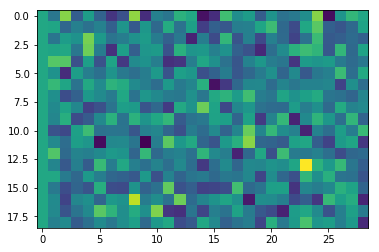

In [33]:
# Initialize empty x
X = np.zeros((n,p))

# First column is intercept
X[:,0] = 1

# Rest of the columns we will make random noise 
X[:,1:] = np.random.randn(n*(p-1)).reshape((n,(p-1)))

# Image of the last 20 rows of X
imshow(X[-20:-1,:])


#### Random Effects matrix (Z)

For simplicity, in this example $Z$ is the same for all voxels. 

[8]
[1]
(160, 8)


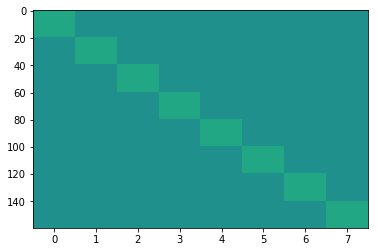

In [34]:
# We need to create a block of Z for each level of each factor
for i in np.arange(r):
  
  for j in np.arange(nlevels[i]):
    
    # Initialize block
    Zij = np.zeros((20,nparams[i]))
    
    # We give the first grouping factor an intercept
    # and make the rest noise
    if i==0:
      
      Zij[:,0] = 1
      Zij[:,1:] = np.random.randn(20*(nparams[i]-1)).reshape((20,(nparams[i]-1)))
      
    else:
      
      Zij[:,:] = np.random.randn(20*nparams[i]).reshape((20,nparams[i]))
    
    # Convert to sparse
    Zij = scipy.sparse.csr_matrix(Zij)
    
    # Initialize Z on first iteration and add to it after
    if (i==0) & (j==0):
      
      Z = Zij

    else:

      # Add block to Z
      Z = scipy.sparse.block_diag((Z, scipy.sparse.csr_matrix(Zij)))

Z2 = sparse.COO.from_scipy_sparse(Z)

# Create an image of Z'
imshow(Z.toarray(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

print(nlevels)
print(nparams)
print(Z.shape)


#### Smooth random beta
Smooth random beta image.

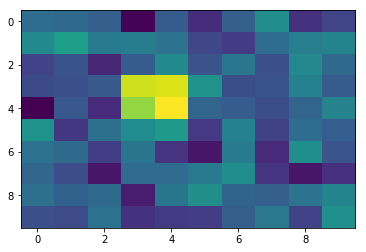

In [35]:
# Random 4D matrix (unsmoothed)
beta_us = np.random.randn(1000*p).reshape(10,10,10,p)*20
beta_us[3:5,3:5,3:5,3] = beta_us[3:5,3:5,3:5,3] + 100

# Some random affine, not important for this simulation
affine = np.diag([1, 1, 1, 1])
beta_us_nii = nib.Nifti1Image(beta_us, affine)

# Smoothed beta nifti
beta_s_nii = nilearn.image.smooth_img(beta_us_nii, 5)

# Final beta
beta = beta_s_nii.get_fdata()

# Show unsmoothed
imshow(beta_us[3,:,:,3].reshape(10,10), \
                    interpolation='nearest', aspect='auto')

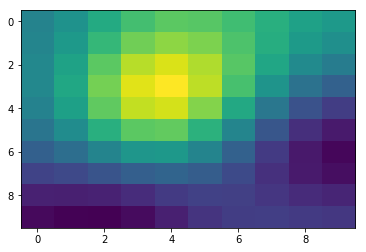

In [36]:
# Show smoothed
imshow(beta[3,:,:,3].reshape(10,10), \
                    interpolation='nearest', aspect='auto')

#### Smooth random b
Smooth random b image.

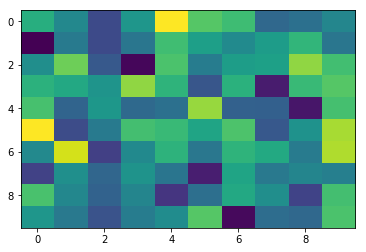

In [37]:
# Random 4D matrix (unsmoothed)
b_us = np.random.randn(1000*q).reshape(10,10,10,q)*20

# Some random affine, not important for this simulation
affine = np.diag([1, 1, 1, 1])
b_us_nii = nib.Nifti1Image(b_us, affine)

# Smoothed beta nifti
b_s_nii = nilearn.image.smooth_img(b_us_nii, 5)

# Final beta
b = b_s_nii.get_fdata()

# Show unsmoothed
imshow(b_us[3,:,:,1].reshape(10,10), \
                    interpolation='nearest', aspect='auto')

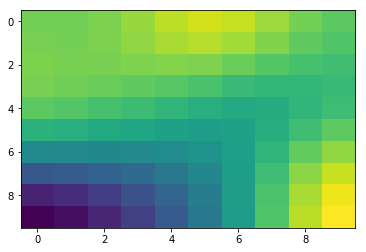

In [38]:
# Show smoothed
imshow(b[3,:,:,1].reshape(10,10), \
                    interpolation='nearest', aspect='auto')

 #### Y vector (New response)
 
Generate response for the whole field.

In [0]:
# Reshape X
X = X.reshape(1, X.shape[0], X.shape[1])

# Reshape beta
beta = beta.reshape(beta.shape[0]*beta.shape[1]*beta.shape[2],beta.shape[3],1)

# Reshape Z (note: This step is slow because of the sparse to dense conversion;
# it could probably be made quicker but this is only for one simulation at current)
Ztmp = Z.toarray().reshape(1, Z.shape[0], Z.shape[1])

# Reshape b
b = b.reshape(b.shape[0]*b.shape[1]*b.shape[2],b.shape[3],1)

# Generate Y
Y = np.matmul(X,beta)+np.matmul(Ztmp,b) + np.random.randn(n,1)

Check Y looks reasonable.

(1000, 160, 1)


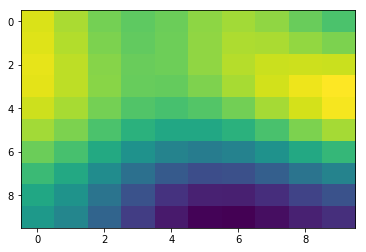

In [40]:
print(Y.shape)

Y_imageformat = Y.reshape((10,10,10,n))

imshow(Y_imageformat[3,:,:,1].reshape(10,10), \
                    interpolation='nearest', aspect='auto')

#### Transpose products

Calculate X'Y, X'Z, X'Y, Y'Y, Y'Z, Y'X Z'Z, Z'X and Z'Y.

In [41]:
# X'Z\Z'X
XtZ = np.matmul(X.transpose(0,2,1),Ztmp)
ZtX = XtZ.transpose(0,2,1)

# Z'Y\Y'Z
YtZ = np.matmul(Y.transpose(0,2,1),Ztmp)
ZtY = YtZ.transpose(0,2,1)

# Y'X/X'Y
YtX = np.matmul(Y.transpose(0,2,1),X)
XtY = YtX.transpose(0,2,1)

# YtY
YtY = np.matmul(Y.transpose(0,2,1),Y)

# ZtZ
ZtZ = np.matmul(Ztmp.transpose(0,2,1),Ztmp)

# X'X
XtX = np.matmul(X.transpose(0,2,1),X)


print(XtZ.shape)
print(ZtX.shape)

print(XtY.shape)
print(YtX.shape)

print(YtZ.shape)
print(ZtY.shape)

print(XtX.shape)

print(YtY.shape)

print(ZtZ.shape)

(1, 29, 8)
(1, 8, 29)
(1000, 29, 1)
(1000, 1, 29)
(1000, 1, 8)
(1000, 8, 1)
(1, 29, 29)
(1000, 1, 1)
(1, 8, 8)


### Demonstration: Time taken just looping

This is a demonstration showing how long PLS takes when doing each voxel seperately.

<class 'cvxopt.base.spmatrix'>
(8, 8)
Time taken in seconds for this example:
2.1264989376068115
Estimated time taken for this example on a nifti of size (100x100x100), in hours:
0.5906941493352255
True beta (3)


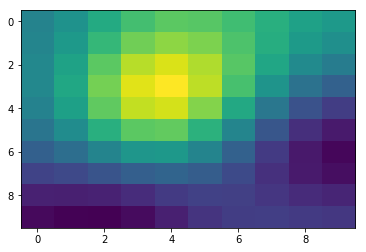

In [42]:
# Initialize empty estimates
beta_est = np.zeros(beta.shape)

# Initialize temporary X'X, X'Z, Z'X and Z'Z
XtZtmp = matrix(XtZ[0,:,:])
ZtXtmp = matrix(ZtX[0,:,:])
ZtZtmp = cvxopt.sparse(matrix(ZtZ[0,:,:]))
XtXtmp = matrix(XtX[0,:,:])

# Initial theta value. Bates (2005) suggests using [vech(I_q1),...,vech(I_qr)] where I is the identity matrix
theta0 = np.array([])
for i in np.arange(r):
  theta0 = np.hstack((theta0, mat2vech(np.eye(nparams[i])).reshape(np.int64(nparams[i]*(nparams[i]+1)/2))))
  
# Obtain a random Lambda matrix with the correct sparsity for the permutation vector
tinds,rinds,cinds=get_mapping(nlevels, nparams)
Lam=mapping(np.random.randn(theta0.shape[0]),tinds,rinds,cinds)

print(type(Lam))
print(Lam.size)

# Obtain Lambda'Z'ZLambda
LamtZtZLam = spmatrix.trans(Lam)*cvxopt.sparse(matrix(ZtZtmp))*Lam

# Obtaining permutation for PLS
P=cvxopt.amd.order(LamtZtZLam)

t1 = time.time()
for i in np.arange(beta.shape[0]):
  
  XtYtmp = matrix(XtY[i,:,:]) 
  ZtYtmp = matrix(ZtY[i,:,:]) 
  YtYtmp = matrix(YtY[i,:,:]) 
  YtZtmp = matrix(YtZ[i,:,:])
  YtXtmp = matrix(YtX[i,:,:])
  
  theta_est = minimize(PLS, theta0, args=(ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  
  # Get current beta
  beta_current = PLS_getBeta(theta_est, ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds)
  beta_est[i,:,:] = beta_current[:]
  
t2 = time.time()
print("Time taken in seconds for this example:")
print(t2-t1)
print("Estimated time taken for this example on a nifti of size (100x100x100), in hours:")
print(1000*(t2-t1)/(60*60))

print("True beta (3)")
beta_map=beta.reshape(10,10,10,beta.shape[1])
beta_est_map=beta_est.reshape(10,10,10,beta.shape[1])

# Show true beta, 3rd x-slice, 3rd parameter
imshow(beta_map[3,:,:,3].reshape(10,10), \
                    interpolation='nearest', aspect='auto')


Estimated beta (3)


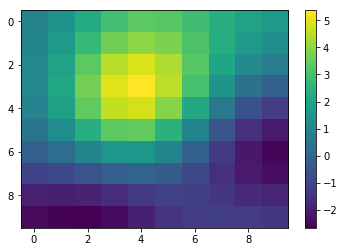

In [43]:
print("Estimated beta (3)")

# Show estimated beta, 3rd x-slice, 3rd parameter
imshow(beta_est_map[3,:,:,3].reshape(10,10), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()


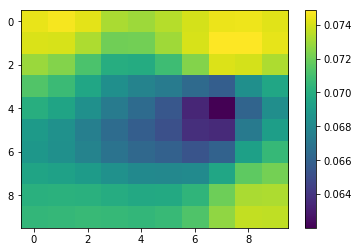

In [44]:
# Sanity check, lets look at the differences
imshow((beta_est_map[3,:,:,3]-beta_map[3,:,:,3]).reshape(10,10), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

Now, let's try the neighbour method, see how the results change.

**Conclusion:** The added penalty had neglible effect.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Time taken in seconds for this example:
2.7879021167755127
Estimated time taken for this example on a nifti of size (100x100x100), in hours:
0.7744172546598647


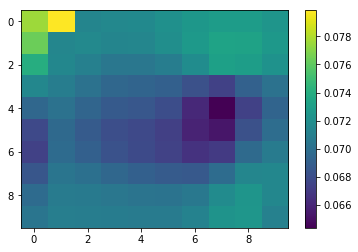

In [45]:
t1 = time.time()
for i in np.arange(beta.shape[0]):
  
  XtYtmp = matrix(XtY[i,:,:]) 
  ZtYtmp = matrix(ZtY[i,:,:]) 
  YtYtmp = matrix(YtY[i,:,:]) 
  YtZtmp = matrix(YtZ[i,:,:])
  YtXtmp = matrix(YtX[i,:,:])
  
  if i==0:
    theta_est = minimize(PLS, theta0, args=(ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  else:
    theta_est = minimize(PLSneighbour, theta0, args=(beta_current, ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x

  # Get current beta
  beta_current = PLS_getBeta(theta_est, ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds)
  beta_est[i,:,:] = beta_current[:]
  
t2 = time.time()
print("Time taken in seconds for this example:")
print(t2-t1)
print("Estimated time taken for this example on a nifti of size (100x100x100), in hours:")
print(1000*(t2-t1)/(60*60))

# Lets look at the differences
beta_map=beta.reshape(10,10,10,beta.shape[1])
beta_est_map=beta_est.reshape(10,10,10,beta.shape[1])
imshow((beta_est_map[3,:,:,3]-beta_map[3,:,:,3]).reshape(10,10), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

Lets try checking the re-used starting point method.

**Conclusion:** Often marked improvement in terms of time efficiency!

Time taken in seconds for this example:
1.7623059749603271
Estimated time taken for this example on a nifti of size (100x100x100), in hours:
0.48952943748897976


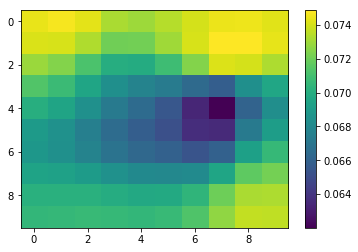

In [46]:
t1 = time.time()
for i in np.arange(beta.shape[0]):
  
  XtYtmp = matrix(XtY[i,:,:]) 
  ZtYtmp = matrix(ZtY[i,:,:]) 
  YtYtmp = matrix(YtY[i,:,:]) 
  YtZtmp = matrix(YtZ[i,:,:])
  YtXtmp = matrix(YtX[i,:,:])
  
  if i==0:
    theta_est = minimize(PLS, theta0, args=(ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
  else:
    theta_est = minimize(PLS, theta_est, args=(ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds), method='L-BFGS-B', tol=1e-6).x
    
  # Get current beta
  beta_current = PLS_getBeta(theta_est, ZtXtmp, ZtYtmp, XtXtmp, ZtZtmp, XtYtmp, YtXtmp, YtZtmp, XtZtmp, YtYtmp, n, P,tinds, rinds, cinds)
  beta_est[i,:,:] = beta_current[:]
  
t2 = time.time()
print("Time taken in seconds for this example:")
print(t2-t1)
print("Estimated time taken for this example on a nifti of size (100x100x100), in hours:")
print(1000*(t2-t1)/(60*60))

# Lets look at the differences
beta_map=beta.reshape(10,10,10,beta.shape[1])
beta_est_map=beta_est.reshape(10,10,10,beta.shape[1])
imshow((beta_est_map[3,:,:,3]-beta_map[3,:,:,3]).reshape(10,10), \
                    interpolation='nearest', aspect='auto')
plt.colorbar()

### Idea 3: Broadcast everything we **can**

The title for this idea speaks for itself. The only operations that cannot be broadcast are those that must be done in `cvxopt`, the only for which it is absolutely must use `cvxopt` is the sparse cholesky decomposition.

In [0]:
# Try dask formatting first
import dask.array as da

XtX_da = da.from_array(XtX, chunks=(1, 10, 10))
XtY_da = da.from_array(XtY, chunks=(10, 10, 10))
XtZ_da = da.from_array(XtZ, chunks=(1, 10, 10))
YtX_da = da.from_array(YtX, chunks=(10, 10, 10))
YtY_da = da.from_array(YtY, chunks=(10, 1, 1))
YtZ_da = da.from_array(YtZ, chunks=(10, 10, 10))
ZtX_da = da.from_array(ZtX, chunks=(1, 10, 10))
ZtY_da = da.from_array(ZtY, chunks=(1, 10, 10))
ZtZ_da = da.from_array(ZtZ, chunks=(1, 10, 10))

nv = 10*10*10 # Number of voxels

#### Helper functions for idea 3

Idea 3 needs broadcasted equivalents of the previous functions; these are given below:

#### Get the 3D mapping

This function returns a 3D mapping equivalent to the previous mapping from a vector of parameters, theta, to indices which maps the parameters the to lower triangular block diagonal matrix, lambda; but for every voxel.

---
The following inputs are required for this function:

---

 - **nlevels**: a vector of the number of levels for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2.
 - **nparams**: a vector of the number of variables for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.
 - **nv**: The number of voxels the mapping is required for.

All arrays must be np arrays.

Note: It is assumed that all voxels have the same mapping here, i.e. they all have the same number of parameters and levels. This could be removed if needed but I suggest removing this assumption would have little practical use.

In [0]:
def get_3D_mapping(nlevels, nparams, nv):

    # Work out the 2D mapping for one voxel
    theta_repeated_inds, row_indices, col_indices = get_mapping(nlevels, nparams)
    
    # Repeat the row and column indices for each voxel
    row_indices_3D = np.tile(row_indices, nv)
    col_indices_3D = np.tile(col_indices, nv)
    
    # Make an array for the coordinate representing which voxel we are looking 
    # at.
    vox_indices_3D = np.repeat(np.arange(nv), len(col_indices))
    
    # Make 3D theta indices
    theta_indices_3D = np.tile(theta_repeated_inds, nv)#+vox_indices_3D*len(col_indices)#Not correct 
    
    
    for i in -np.arange(len(theta_indices_3D)):
      if vox_indices_3D[i] != vox_indices_3D[i-1] and vox_indices_3D[i] != 0:
        theta_indices_3D[i:] = theta_indices_3D[i:] + theta_indices_3D[i-1] + 1
    
    # Return 
    return(theta_indices_3D.astype(np.int64), row_indices_3D.astype(np.int64), col_indices_3D.astype(np.int64), vox_indices_3D.astype(np.int64))

theta_indices_3D, row_indices_3D, col_indices_3D, vox_indices_3D = get_3D_mapping(nlevels, nparams, nv)


### Apply 3D mapping function

The below function applies a mapping to a vector of parameters for a list of voxels.

---
The following inputs are required for this function:

---

 - **theta**: the vector of theta parameters for all voxels (i.e. if one voxel has 6 parameters and there are 10 voxels, then theta is 60 by 1 and laid out as [$p_1$,$p_2$,...,$p_{10}$] where $p_n$ is the parameter vector for voxel n.
 - **v_inds**: A vector specifying which voxel each entry in the theta vector belongs to. E.g. v_inds[i]=j means the $i^{th}$ parameter entry belongs to voxel $j$.
 - **t_inds**: A vector specifying how many times each theta parameter should be repeated. For example, if theta=[0.1,0.8,0.3] and theta_inds=[0,0,0,1,2,2], then the values to be mapped into the sparse matrix would be [0.1,0.1,0.1,0.8,0.3,0.3].
 - **r_inds**: The row indices of the elements mapped into the sparse matrix.
 - **c_inds**: The column indices of the elements mapped into the sparse matrix.

In [50]:
def mapping_3D(theta, v_inds, t_inds, r_inds, c_inds):
  
  # Create the coordinate matrix
  coords = np.array([v_inds, r_inds, c_inds])

  # Create Lambda
  lam = sparse.COO(coords, theta[t_inds.astype(np.int64)].tolist(), shape=(np.max(v_inds)+1,np.max(r_inds)+1,np.max(c_inds)+1))

  return(lam)

# Random theta to test with
print(len(theta_indices_3D))
print(np.max(theta_indices_3D))
theta = np.random.randn(np.int16((np.sum((nparams*(nparams+1)/2)))*nv))

# Get lambda
lam = mapping_3D(theta, vox_indices_3D, theta_indices_3D, row_indices_3D, col_indices_3D)

8000
999


#### Initial Theta function

The below function calculates the initial theta vector for the whole brain.

---
The following inputs are required for this function:

---
 - nv: The number of voxels.
 - nparams: The number of parameters vector.

In [52]:
def init_theta(nv, nparams):
  
  for nump in nparams:
    
    print(np.arange(nump,2))
    
init_theta(nv,nparams)


[1]


#### Broadcasted (Dask) PLS function

Commented lines still need doing... documentation also coming soon...

In [53]:
def PLS_broadcasted(theta, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, tinds, rinds, cinds, vinds):

    # Obtain Lambda
    Lambda = mapping_3D(theta[:], tinds, rinds, cinds)
    
    # Obtain Lambda'
    Lambdat = Lambda.transpose((0,2,1))

    # Obtain Lambda'Z'Y and Lambda'Z'X
    LambdatZtY = np.matmul(Lambdat,ZtY)
    LambdatZtX = np.matmul(Lambdat,ZtX)

    # Obtain the cholesky decomposition numpy.linalg.cholesky
    #LambdatZtZLambda = Lambdat*ZtZ*Lambda
    #I = spmatrix(1.0, range(Lambda.size[0]), range(Lambda.size[0]))
    #chol_dict = sparse_chol(LambdatZtZLambda+I, perm=P, retF=True, retP=False, retL=False)
    #F = chol_dict['F']

    # Obtain C_u (annoyingly solve writes over the second argument,
    # whereas spsolve outputs)
    #Cu = LambdatZtY[P,:]
    #cholmod.solve(F,Cu,sys=4)

    # Obtain RZX
    #RZX = LambdatZtX[P,:]
    #cholmod.solve(F,RZX,sys=4)

    # Obtain RXtRX
    #RXtRX = XtX - matrix.trans(RZX)*RZX

    # Obtain beta estimates (note: gesv also replaces the second
    # argument)
    #betahat = XtY - matrix.trans(RZX)*Cu
    #lapack.posv(RXtRX, betahat)

    # Obtain u estimates
    #uhat = Cu-RZX*betahat
    #cholmod.solve(F,uhat,sys=5)
    #cholmod.solve(F,uhat,sys=8)

    # Obtain b estimates
    #bhat = Lambda*uhat

    # Obtain residuals sum of squares
    #resss = YtY-2*YtX*betahat-2*YtZ*bhat+2*matrix.trans(betahat)*XtZ*bhat+matrix.trans(betahat)*XtX*betahat+matrix.trans(bhat)*ZtZ*bhat

    # Obtain penalised residual sum of squares
    #pss = resss + matrix.trans(uhat)*uhat

    # Obtain Log(|L|^2)
    #logdet = 2*sum(cvxopt.log(cholmod.diag(F)))

    # Obtain log likelihood
    #logllh = -logdet/2-n/2*(1+np.log(2*np.pi*pss)-np.log(n))

    return(-1)
  
# Need to make theta0


PLS_broadcasted(theta, ZtX, ZtY, XtX, ZtZ, XtY, YtX, YtZ, XtZ, YtY, n, P, tinds, rinds, cinds, vinds)

NameError: ignored

### Idea 4: Large sparse diagonals

Below is a brief concept check... it didn't work consistently.

In [0]:
# Concept check
LamtZtZLam2 = LamtZtZLam
t1 = time.time()
for i in np.arange(100):
  LamtZtZLam2 = cvxopt.spdiag([LamtZtZLam2,LamtZtZLam])
f=sparse_chol(LamtZtZLam2)
t2 = time.time()
print(t2-t1)

t1 = time.time()
for i in np.arange(101):
  f=sparse_chol(LamtZtZLam)
t2 = time.time()
print(t2-t1)

### Sandbox

In [59]:
import cvxopt.amd
import cvxopt
import numpy as np
import dask.array as da

runningnptime=np.zeros(1000)
runningsptime=np.zeros(1000)
runningdatime=np.zeros(1000)
runningdaptime=np.zeros(1000)

for n in np.arange(1000):
  for i in np.arange(10):
    print(n)
    print(i)
    X = np.random.randn(n+1,n+1)
    X[X<2.1]=0
    X = X + np.eye(n+1)

    XtX = np.matmul(X.transpose(), X)

    XtX_cvxopt = cvxopt.sparse(cvxopt.matrix(XtX))
    P = cvxopt.amd.order(XtX_cvxopt)

    P_np = np.array(P[:]).reshape(n+1)

    #print(P_np)
    # To get the permuted X from the amd ordering must do X[:,P]
    XtX_P = np.matmul((X[:,P_np]).transpose(),X[:,P_np])

    #print(X[P_np,:].shape)

    XtX_P_cvxopt = XtX_cvxopt[P,P]

    #print(XtX_P)
    #print(XtX_P_cvxopt)

    #print(cvxopt.sparse(cvxopt.matrix(XtX_P))-XtX_P_cvxopt)


    F=sparse_chol(XtX_cvxopt, perm=None, retF=False, retP=True, retL=True)

    L_cvxopt_spchol = F['L']

    #print(L_cvxopt_spchol*spmatrix.trans(L_cvxopt_spchol)-cvxopt.sparse(cvxopt.matrix(XtX_P)))

    t1 = time.time()
    L_np_chol = np.linalg.cholesky(XtX)
    t2 = time.time()
    nptime=t2-t1

    t1 = time.time()
    L_np_spchol = np.linalg.cholesky(XtX_P)
    t2 = time.time()
    sptime=t2-t1
    
    XtX_da = da.from_array(XtX, chunks=(10, 10)).map_blocks(sparse.COO).rechunk('auto')
    XtX_da_P = da.from_array(XtX_P, chunks=(10, 10)).map_blocks(sparse.COO).rechunk('auto')
    
    t1 = time.time()
    L_np_chol = da.linalg.cholesky(XtX_da)
    t2 = time.time()
    datime=t2-t1

    t1 = time.time()
    L_np_spchol = da.linalg.cholesky(XtX_da_P)
    t2 = time.time()
    daptime=t2-t1

    runningnptime[n] = runningnptime[n] + nptime
    runningsptime[n] = runningsptime[n] + sptime
    runningdatime[n] = runningdatime[n] + datime
    runningdaptime[n] = runningdaptime[n] + daptime
  


0
0
0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9
1
0
1
1
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
2
0
2
1
2
2
2
3
2
4
2
5
2
6
2
7
2
8
2
9
3
0
3
1
3
2
3
3
3
4
3
5
3
6
3
7
3
8
3
9
4
0
4
1
4
2
4
3
4
4
4
5
4
6
4
7
4
8
4
9
5
0
5
1
5
2
5
3
5
4
5
5
5
6
5
7
5
8
5
9
6
0
6
1
6
2
6
3
6
4
6
5
6
6
6
7
6
8
6
9
7
0
7
1
7
2
7
3
7
4
7
5
7
6
7
7
7
8
7
9
8
0
8
1
8
2
8
3
8
4
8
5
8
6
8
7
8
8
8
9
9
0
9
1
9
2
9
3
9
4
9
5
9
6
9
7
9
8
9
9
10
0
10
1
10
2
10
3
10
4
10
5
10
6
10
7
10
8
10
9
11
0
11
1
11
2
11
3
11
4
11
5
11
6
11
7
11
8
11
9
12
0
12
1
12
2
12
3
12
4
12
5
12
6
12
7
12
8
12
9
13
0
13
1
13
2
13
3
13
4
13
5
13
6
13
7
13
8
13
9
14
0
14
1
14
2
14
3
14
4
14
5
14
6
14
7
14
8
14
9
15
0
15
1
15
2
15
3
15
4
15
5
15
6
15
7
15
8
15
9
16
0
16
1
16
2
16
3
16
4
16
5
16
6
16
7
16
8
16
9
17
0
17
1
17
2
17
3
17
4
17
5
17
6
17
7
17
8
17
9
18
0
18
1
18
2
18
3
18
4
18
5
18
6
18
7
18
8
18
9
19
0
19
1
19
2
19
3
19
4
19
5
19
6
19
7
19
8
19
9
20
0
20
1
20
2
20
3
20
4
20
5
20
6
20
7
20
8
20
9
21
0
21
1
21
2
21
3
21
4
21
5
21
6
21
7
21
8
21
9


5.108451128005982e-06
3.065649032592773e-06


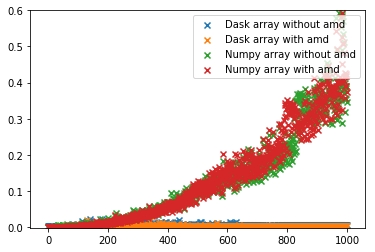

In [92]:


print(np.mean(runningdatime/1000))
print(np.mean(runningdaptime/1000))

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.arange(1000),runningdatime, marker="x", label='Dask array without amd')
ax1.scatter(np.arange(1000),runningdaptime, marker="x", label='Dask array with amd')
ax1.scatter(np.arange(1000),runningnptime, marker="x", label='Numpy array without amd')
ax1.scatter(np.arange(1000),runningsptime, marker="x", label='Numpy array with amd')
plt.legend(loc='upper right');
plt.ylim(-0.002, 0.6)
plt.show()